Sem Segmentation Scoring Pipeline
Load TF Model

In [428]:
# scoring module is pasted in the downloads directory!
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#import sys
#sys.path.insert(0, "../Home/segmentation_pipeline/scoring")

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from glob import glob
from parse import parse
%matplotlib inline
import tensorflow as tf
import random
import tensorflow.contrib.layers as lays
import tensorflow.contrib.slim as slim
import multiprocessing
import itertools
from skimage import measure
from skimage import filters
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import scoring
import plotly
print(plotly.__version__)  # version >1.9.4 required
import plotly.graph_objs as go

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import inconsistent
# Clustering
from scipy.cluster.hierarchy import dendrogram, fcluster, leaves_list
from scipy.spatial import distance

def convert_to_image(path, system='sing', noise = True, varsM=['MeanDoCA','Mu', 'SmoothedNumPoCAs']):
    df = pd.read_csv(path)
    #df = df[df['z']>300]
    nx = len(df.x.unique())
    ny = len(df.y.unique())
    nz = len(df.z.unique())
    df = df.sort_values(by=['z','y','x'])
    #image = df[varsM].values.reshape(-1,nx,ny,nz)
    ## normalize
    #df[varsM] = (df[varsM] - df[varsM].min())/(df[varsM].max()-df[varsM].min())
    df[varsM] = (df[varsM] - df[varsM].min())/(df[varsM].std())
    if noise:
        df[varsM] = df[varsM].apply(lambda x: x + 3*np.random.rand()/1)
    image = df[varsM].to_records(index=False).reshape(nx,ny,nz)
    image = np.array(image.tolist())
    # reshape the volume so the deconvolutio would work
    image = pad_along_axis(image,12,axis=0)
    image = pad_along_axis(image,12,axis=2)
    image = np.delete(image, 1, axis=1)
    if system=='hmt_apg':
        listofMaterials = ['ClutterA','ANFO','ClutterC','AN','Sugar', 'ClutterB','PCFO']
    if system=='sing':
        listofMaterials = ['Cigarettes', 'PPC', 'SodiumNitrate', 'WheatFlour', 'Textiles']
    materialsPresent = df.columns.intersection(listofMaterials)
    if len(materialsPresent) >0:
        #df['AirOrNot'] = df[materialsPresent].apply(lambda row: 1 if sum(row)<=0.00 else 0, axis=1)
        df['AirOrNot'] = df[materialsPresent].apply(lambda row: 1 if sum(row)<=0.0 else 
                                                    2 if sum(row)>0.0 and sum(row)<=0.2 else 0 , axis=1)
        #df['AirOrNot'] = df[materialsPresent].apply(lambda row: 1 - sum(row), axis=1)
    else:
        df['AirOrNot'] = 1
    nxn = 12
    nyn = 24
    nzn = 12
    annotations = df['AirOrNot'].values.reshape(nx,ny,nz)
    annotations = pad_along_axis(annotations,12,axis=0)
    annotations = pad_along_axis(annotations,12,axis=2)
    annotations = np.delete(annotations, 0, axis=1)
    if noise:
        positions = random.randint(-1000,1000)
        image = np.roll(image, positions, axis=0)
        annotations = np.roll(annotations, positions, axis=0)
    return image, annotations

## 0 is my material, so I need to pad 1s for air
##
def pad_along_axis(array, target_length, axis=0):
    pad_size = target_length - array.shape[axis]
    axis_nb = len(array.shape)
    if pad_size < 0:
        return a
    npad = [(0, 0) for x in range(axis_nb)]
    npad[axis] = (0, pad_size)
    b = np.pad(array, pad_width=npad, mode='constant', constant_values=1)
    return b

def get_batches_fn(batch_size, image_path,x, y, z, shuffle = True, varsM=['MeanDoCA','Mu', 'SmoothedNumPoCAs'], 
                   trainflag='Train', system='sing', eval_phase=False, datasettype='ds'):
    '''
    Create batches, restricting the number of scans per run included. 
    sample was on 2 scans per run, changed to 10 
    '''
    if eval_phase==False:
        m = image_path.groupby('run', group_keys=False).apply(lambda x: x.sample(min(len(x), 150)))
        if shuffle:
            shuffled = random.sample(m['filepath'].values, batch_size)
        else:
            shuffled = image_path['filepath'].values
        images = []
        labels = []
        for im_path in shuffled:
            if trainflag=='Train':
                image, anno = convert_to_image(im_path,system, True, varsM)
            else:
                image, anno = convert_to_image(im_path,system,False, varsM)
            images.append(image)
            labels.append(anno)
        labels = np.array(labels).reshape(batch_size, x*y*z)
        images = np.array(images)
        return tf.convert_to_tensor(images, dtype = tf.float32), tf.convert_to_tensor(labels, dtype = tf.float32)
    if eval_phase ==True and datasettype=='vtp':
        images = []
        for im_path in image_path:
            df = vtp_to_df(im_path)
            nx = len(df.x.unique())
            ny = len(df.y.unique())
            nz = len(df.z.unique())
            df[varsM] = (df[varsM] - df[varsM].min())/(df[varsM].std())
            image = df[varsM].to_records(index=False).reshape(nx,ny,nz)
            image = np.array(image.tolist())
            # reshape the volume so the deconvolution would work
            image = pad_along_axis(image,12,axis=0)
            image = pad_along_axis(image,12,axis=2)
            image = np.delete(image, 0, axis=1)
            images.append(image)
        images = np.array(images)
        return tf.convert_to_tensor(images, dtype = tf.float32)
    if eval_phase ==True and datasettype=='ds':
        images = []
        labels = []
        for im_path in image_path:
            image, anno = convert_to_image(im_path,system,False, varsM)
            images.append(image)
            labels.append(anno)
        labels = np.array(labels).reshape(1,12,24,12)
        images = np.array(images)
        return tf.convert_to_tensor(images, dtype = tf.float32), tf.convert_to_tensor(labels, dtype = tf.float32)

def noisetosignal_q75(y):
    x1 = np.divide(y.quantile(0.90), np.std(y), out=np.zeros_like(y.quantile(0.90)), where=np.std(y)!=0)
    return x1

def median_v(y):
    x1 = y.quantile(0.50)
    return x1

def noisetosignal_sdmed(y):
    x1 = np.divide(np.std(y), np.mean(y), out=np.zeros_like(y.quantile(0.90)), where=np.mean(y)!=0)
    return x1    

def matchLabels(clustering, truth):  
    materials = truth.unique()
    df = pd.concat([truth,clustering, clustering], axis=1)
    df.columns=['Cat','AssignedMaterials', 'AssignedMaterials1']
    dfLabels = pd.concat([pd.DataFrame(clustering.unique()),pd.DataFrame(clustering.unique())], axis=1)
    dfLabels.columns = ['OldLabel','NewLabel']
    crosstab = pd.crosstab(df['AssignedMaterials'],df['Cat'])
    crosstab['mat1'] = crosstab.apply(lambda row: row.idxmax(), axis=1)
    crosstab['OldLabel'] = crosstab.index
    crosstab['NewLabel'] = crosstab.index
    # only keep 1 material per max and align the max label with the material label
    for i in crosstab['mat1'].unique():
        if sum(crosstab['mat1']==i)==1:
            crosstab.loc[crosstab.mat1==i, 'NewLabel']=crosstab.loc[crosstab.mat1==i, 'mat1']
        else:    
            labels = range(i,sum(crosstab['mat1']==i)+len(materials))
            labels1 = set(labels)- set(materials[materials<>i])
            labels1 = list(labels1)[0:sum(crosstab['mat1']==i)]
            crosstab.loc[crosstab.mat1==i, 'NewLabel'] = list(labels1)
    # change the clustering labels to match
    for i in crosstab['OldLabel'].unique():
        if int(crosstab.loc[crosstab.OldLabel==i, 'OldLabel']) <> int(crosstab.loc[crosstab.OldLabel==i, 'NewLabel']):
            df.loc[df.AssignedMaterials1==i, 'AssignedMaterials'] = int(crosstab.loc[crosstab.OldLabel==i, 'NewLabel'])
    return df[['AssignedMaterials']]


parsedlisttest=pd.read_csv('parsedlisttestSing.csv')
parsedlisttrain=pd.read_csv('parsedlisttrainSing.csv')

2.5.1


In [5]:
# newt needs to be divisible by 10 as the batch size is 10
#newt = parsedlisttest.groupby('run', group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))
parsedlisttest_600 = parsedlisttest[parsedlisttest['secs']>=300]
newt = parsedlisttest_600.groupby('run', group_keys=False).apply(lambda x: x.sample(min(len(x), 1)))
len(newt)
newt#[0:10]

,Unnamed: 0,filepath,run,scan,secs
126,126,/storage/opt/dsc/dse/sing/release/3.4.19/outpu...,10,6,510
342,22,/storage/opt/dsc/dse/sing/release/3.4.19/outpu...,11,7,540
490,30,/storage/opt/dsc/dse/sing/release/3.4.19/outpu...,16,2,420
923,323,/storage/opt/dsc/dse/sing/release/3.4.19/outpu...,19,7,390
1089,149,/storage/opt/dsc/dse/sing/release/3.4.19/outpu...,22,4,360
1560,280,/storage/opt/dsc/dse/sing/release/3.4.19/outpu...,24,12,300
2089,369,/storage/opt/dsc/dse/sing/release/3.4.19/outpu...,37,5,510
2436,316,/storage/opt/dsc/dse/sing/release/3.4.19/outpu...,47,13,330


In [415]:
# Scoring and clustering csv datasets
x=12#22
y = 24#46
z = 12#18#22
batch_size =1
#varsM=['FracMu', 'box_p95','ScatteringRatio', 'n_3sigma','StoppedMeanP', 'SmoothedNumPoCAs', 
#         'StoppedThroughRatio', 'PoCAScat']
varsM = ['FracMu', 'box_p95','ScatteringRatio', 'n_3sigma','StoppedMeanP', 'SmoothedNumPoCAs', 
         'StoppedThroughRatio', 'PoCAScat']

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth=False)
#config = tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)

config = tf.ConfigProto(intra_op_parallelism_threads=4,#multiprocessing.cpu_count(), 
                        inter_op_parallelism_threads=4,#multiprocessing.cpu_count(), 
                        log_device_placement=True,
                        gpu_options=gpu_options,
                        allow_soft_placement=True, 
                        device_count = {'CPU' : 8, 
                                        'GPU' : 0}
                       )

predfull=[]
loaded_graph = tf.Graph()

session2 = tf.InteractiveSession(graph = loaded_graph, config=config)
saver = tf.train.import_meta_graph("Documents/AirNoAirTF/TFSelectedSing_12_3Classes.meta")
saver.restore(session2,'Documents/AirNoAirTF/TFSelectedSing_12_3Classes')
fcn_outputs = loaded_graph.get_tensor_by_name("fcn_outputs:0")
input_images = loaded_graph.get_tensor_by_name("input_images:0")
input_labels = loaded_graph.get_tensor_by_name("input_labels:0")
phase = loaded_graph.get_tensor_by_name("phase:0")
keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")

# newt has 70 items right now
for i in range(0,len(newt), batch_size): 
    eval_images1, eval_labels1 = get_batches_fn(batch_size, newt['filepath'].values[i:(i+batch_size)], x, y, z, True, 
                                                varsM, 'Test','sing', True, datasettype='ds')
    test_x, test_y = session2.run([eval_images1, eval_labels1])
    pred1 = session2.run([fcn_outputs], feed_dict={input_images: test_x, phase:'False', 
                                               keep_prob:'1.0'})
    predfull.append(pred1)
    print(i)


INFO:tensorflow:Restoring parameters from Documents/AirNoAirTF/TFSelectedSing_12_3Classes
0
1
2
3
4
5
6
7


In [297]:
#predfull_model7 = predfull[:]
newt['filepath'].values[i:(i+batch_size)]
df = pd.read_csv(samples['filepath'].values[pp])
df[['x','y','z']]#.sort_values(by=['z','y','x'])

,x,y,z
0,215.0,765.0,255.0
1,245.0,765.0,255.0
2,275.0,765.0,255.0
3,305.0,765.0,255.0
4,335.0,765.0,255.0
5,365.0,765.0,255.0
6,395.0,765.0,255.0
7,425.0,765.0,255.0
8,455.0,765.0,255.0
9,485.0,765.0,255.0


In [416]:
quant = 0.90
res = []
variablesforModelingShort = ['FOM', 'FracMu', 'GeoMeanFractionalScattering',
       'GeoMeanPThetaSquared', 'GeoMeanTheta', 'MikesFOM', 'Mu',
       'NumTracks', 'PoCALogScat', 'PoCARate', 'ScatteringRatio',
       'SmoothedNumPoCAs', 'box_mean', 'box_p25', 'box_p50', 'box_p75',
       'box_p95', 'box_std', 'sum_max_1_3', 'sum_max_1_5', 'sum_max_2_2',
       'sum_max_2_5', 'sum_max_3_3', 'sum_max_3_5', 'value_max_2',
       'value_max_3','NumStoppedTracks',"StoppedThroughRatio", 'StoppedMean']

samples = newt
## flatten predful to match 1 scan
flat_predfull = []
for sublist in predfull:
    for item in sublist:
        for scan in item:
            flat_predfull.append(scan)

In [417]:
pp =0
#for pp in range(len(samples)):
df = pd.read_csv(samples['filepath'].values[pp])
listofMaterials = ['Cigarettes', 'PPC', 'SodiumNitrate', 'WheatFlour', 'Textiles','Water'] #['ClutterA','ANFO','ClutterC','AN','Sugar', 'ClutterB','PCFO']
materialsPresent = df.columns.intersection(listofMaterials)
if len(materialsPresent) >0:
    df['AirOrNot'] = df[materialsPresent].apply(lambda row: 1 if sum(row)<=0.10 else 0, axis=1)
    df['Materials'] = df[np.append(materialsPresent,'AirOrNot')].apply(lambda row: row.idxmax() if row['AirOrNot']==0 else 'AirOrNot', axis=1)
    m2 = df['Materials'].unique()
    m_dict = dict(zip(m2, range(len(m2))))
    df['Cat']=df['Materials'].apply(lambda s: m_dict.get(s) if s in m_dict else s)
else:
    df['AirOrNot'] = 1
    df['Cat'] = 0
    df['Materials'] = 'Air'    

interim = np.reshape(flat_predfull[pp], (12,24,12))
interim = np.delete(interim, 11, axis=0)
interim = np.delete(interim, 11, axis=2)
interim = pad_along_axis(interim, 25, axis=1)
labels = np.reshape(interim, (11*25*11))
df['PredictedAir'] = np.round(labels,0)     
dfA = df



In [418]:
pd.crosstab(df.PredictedAir, df.Materials)

Materials,AirOrNot,SodiumNitrate
PredictedAir,,
0,28,24
1,2940,9
2,21,3


In [302]:
dfB = pd.DataFrame.copy(dfA[dfA['PredictedAir']==0])
varsC = ['MeanTheta','PoCAScat','GeoMeanFractionalScattering','MeanDoCA','box_p95',
         'GeoMeanPThetaSquared','Mu', 'MikesFOM', 'FracMu','x','y','StoppedMeanP','StoppedThroughRatio']


dfB[varsC] = (dfB[varsC] - dfB[varsC].mean())/(dfB[varsC].std())

dfB['Int1'] = np.tanh(dfB['GeoMeanFractionalScattering']) #dfB['PoCARate']*dfB['PoCAScat']*dfB['MeanDoCA']
dfB['Int2'] = np.tanh((dfB['MeanDoCA']))
dfB['Int3'] = np.tanh(dfB['GeoMeanPThetaSquared'])
dfB['Int4'] = np.tanh((dfB['Mu']))/dfB['Mu']
dfB['Int5'] = np.tanh((dfB['box_p95']*dfB['StoppedThroughRatio'])) 
dfB['Int6'] = np.tanh((dfB['GeoMeanFractionalScattering']/dfB['StoppedThroughRatio'])) 
dfB['Int7'] = np.tanh((dfB['box_p95']/dfB['GeoMeanPThetaSquared']))
dfB['Int8'] = np.tanh((dfB['box_p95']))/dfB['box_p95']

dfB = dfB[['Int1','Int2']]#,'Int3',,'Int4','Int5','Int6','Int7','Int8']]

test = pdist(dfB, 'cityblock')
test1= pd.DataFrame(squareform(test), index=dfB.index, columns= dfB.index)
tsne_fit = test1
eps1 = abs((pd.DataFrame(tsne_fit).quantile(0.9).quantile(0.9)))
dbs=DBSCAN(eps=float(eps1), min_samples=1, leaf_size=1).fit((tsne_fit))
t=pd.Series(dbs.labels_,index=dfB.index)
    ## end dbscan clustering

s = pd.DataFrame(t.value_counts())
s = pd.DataFrame(t.value_counts())
s.columns=['counts']
s['clusters'] = s.index
s['clusters'] = s['clusters'].apply(lambda x: x if x in s[s['counts'] >3]['clusters'] else -1)
t.value_counts()

0    34
dtype: int64

In [303]:
from scipy.stats import ttest_ind
# assign -1 to anything below 5
s = pd.DataFrame(t.value_counts())
s.columns=['counts']
s['clusters'] = s.index
s['clustersnew'] = s['clusters'].apply(lambda x: x+1 if x in s[s['counts'] >3]['clusters'] else 0)
t1 = pd.DataFrame(t)
t1.columns=['oldclusters']
t1['recordid'] = t1.index
renamed = pd.merge(t1, s, how='outer', left_on='oldclusters', right_on='clusters')
renamed

,oldclusters,recordid,counts,clusters,clustersnew
0,0,409,34,0,1
1,0,411,34,0,1
2,0,420,34,0,1
3,0,673,34,0,1
4,0,674,34,0,1
5,0,675,34,0,1
6,0,684,34,0,1
7,0,685,34,0,1
8,0,686,34,0,1
9,0,687,34,0,1


In [88]:
dfB

,Int1,Int3,Int2,Int4,Int5,Int6,Int7,Int8
264,-0.696944,-0.659882,-0.707819,0.799933,0.293521,0.857454,0.514344,0.937376
265,-0.628906,-0.594656,-0.655712,0.852655,0.455003,0.608495,0.594684,0.932594
266,-0.585570,-0.580928,-0.563142,0.862404,0.742295,0.371533,0.684310,0.908348
267,-0.560760,-0.509991,-0.423231,0.906136,0.626321,0.326266,0.603134,0.951555
268,0.169604,-0.096640,-0.215631,0.999812,0.322160,-0.143027,0.993936,0.974501
269,-0.053574,-0.037555,-0.097506,0.997143,0.379462,0.052153,1.000000,0.952479
270,0.034803,-0.144283,-0.125503,0.999630,0.472791,-0.025040,0.987710,0.956847
271,0.008333,-0.113640,-0.012776,0.999996,0.477324,-0.004709,0.988412,0.972221
272,-0.253074,-0.251384,0.169738,0.990667,0.577915,0.141048,0.887231,0.958515
273,-0.474344,-0.456950,-0.172385,0.932253,0.444725,0.391700,0.651283,0.953659


In [304]:
dfB['joinkey'] = dfB.index
dfB = pd.merge(dfB, renamed, how = 'outer', left_on='joinkey', right_on='recordid')  
dfB['AssignedMaterials'] = dfB['clustersnew']
dfB.index = dfB['joinkey']
dfB['x'] = dfA['x'][dfA['PredictedAir']==0]
dfB['y'] = dfA['y'][dfA['PredictedAir']==0]
dfB['z'] = dfA['z'][dfA['PredictedAir']==0]
dfB.AssignedMaterials = dfB.AssignedMaterials.astype(int)
dfA['AssignedMaterials'] = 0

df3 = dfA[['x','y','z','AssignedMaterials']][(dfA['PredictedAir']==1) | (dfA['PredictedAir']==2)].append(dfB[['x','y','z',
                        'AssignedMaterials']])
df3 = df3.sort_values(by=['z','y','x'])
testIm = df3['AssignedMaterials'].values.reshape(11,25,11)
all_labels = measure.label(testIm, connectivity = 3, background=0)
all_labels_df = pd.DataFrame(all_labels.reshape(11*25*11))
df3['NPObjects'] = all_labels_df
df3.AssignedMaterials = df3.AssignedMaterials.astype(int)
df3['Materials'] = dfA.Materials

s = df3['NPObjects'].value_counts().to_frame()
s['clusters'] = s.index
df3['NPObjects1'] = df3['NPObjects'].apply(lambda x: x if x in s[s['NPObjects'] >2]['clusters'] else 0)

In [305]:
df3['NPObjects1'].value_counts()

0    2991
1      34
Name: NPObjects1, dtype: int64

In [176]:
pd.crosstab(df3['Materials'],df3['NPObjects1'])

NPObjects1,0,1,2
Materials,,,
AirOrNot,2964,18,7
SodiumNitrate,14,4,18


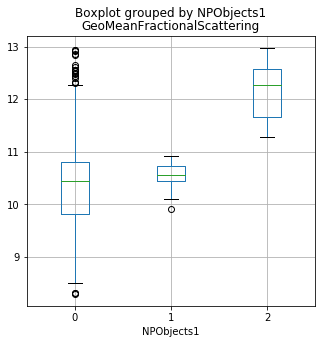

In [175]:
dfA['NPObjects1'] = df3['NPObjects1']
dfA.boxplot('GeoMeanFractionalScattering', by='NPObjects1', figsize=(5,5))


In [306]:
colors = ['rgb(0,0,0)', 'rgb(0,0,255)','rgb(255,0,0)', 'rgb(0,255,0)', 'rgb(0,128,255)', 'rgb(255,0,255)'
          , 'rgb(255,255,51)', 'rgb(255,229,209)', 'rgb(0,255,255)']
opacity_s = ['0.01','1','1','1','1','1','1','1','1']
data = []
plot_var = 'NPObjects1'
for i in range(len(df3[plot_var].unique())):
    name = np.sort(df3[plot_var].unique())[i]
    color = colors[i]
    opacity = opacity_s[i]
    x = df3[ df3[plot_var] == name ]['x']
    y = df3[ df3[plot_var] == name ]['y']
    z = df3[ df3[plot_var] == name ]['z']
    
    trace = dict(
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=5, color=color, line=dict(width=0), opacity=opacity ) )
    data.append( trace )
    
layout = go.Layout(
    title=samples['filepath'].values[pp]
)

#plotly.offline.plot([trace, layout])
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig)    

'file:///home/rvozdolska/Downloads/temp-plot.html'

In [419]:
## scoring part
## scoring only works if the labels are perfectly aligned 
## the revised label function is not working properly as of now
    summary_by_object['AssignedMaterials'] = t
    df3 = df.merge(summary_by_object, left_on='NPObjects', right_on = 'NPObjects_')
    #df3A = df3[df3['AirOrNot']==0]
    df3A = df3[df3['PredictedAir']==0]
    if len(df3A['AssignedMaterials'])>1:
        df3A['RevisedLabels'] = matchLabels(df3A['AssignedMaterials'],df3A['Cat'])
    else:
        df3A['RevisedLabels'] = 0
    df3['RevisedLabels'] = 0
    #df3B = pd.concat([df3A,df3[df3['PredictedAir']==1]], axis=0)
    df3B = pd.concat([df3A,df3[df3['PredictedAir']==1]], axis=0)
    
    newfile = 'MaterialDiscrimination/Scored_'+str(samples['run'].values[pp])+str(samples['scan'].values[pp])+str(samples['secs'].values[pp])+'.csv'
    #df3B[['x','y','z','RevisedLabels','Cat','Materials','AirOrNot','PredictedAir','NPObjects', 'AssignedMaterials']].to_csv(newfile)
    conf_matrix = pd.crosstab(df3B['AssignedMaterials'], df3B['Cat'])
    total_accuracy = sum(1.0*np.diag(conf_matrix))/ conf_matrix.values.sum()
    conf_matrix_mat = conf_matrix.drop(conf_matrix.index[0], axis=0)
    conf_matrix_mat = conf_matrix_mat.drop(conf_matrix_mat.columns[0], axis=1)
    material_accuracy = sum(1.0*np.diag(conf_matrix_mat))/ conf_matrix_mat.values.sum()
    print(total_accuracy,material_accuracy)
    print(conf_matrix)
    print(pp)
    ## our metrics
    try:
        int_over_union_v= scoring.intersection_over_union(df3B.Cat,df3B.AssignedMaterials)
    except:
        int_over_union_v = -1
    try:    
        dice_v = scoring.dice_coefficient(df3B.Cat,df3B.AssignedMaterials)
    except:
        dice_v = -1
    try:
        recall_v = scoring.recall(df3B.Cat,df3B.AssignedMaterials)
    except:
        recall_v = -1
    try:
        precision_v = scoring.precision(df3B.Cat,df3B.AssignedMaterials)
    except:
        precision_v = -1
    try:
        volum_sim_v = scoring.volumetric_similarity(df3B.Cat,df3B.AssignedMaterials)
    except:
        volum_sim_v = -1
    try:
        volum_ratio_v = scoring.volume_ratio(df3B.Cat,df3B.AssignedMaterials)
    except:
        volum_ratio_v = -1
    try:
        mean_int_over_union_v= scoring.mean_intersection_over_union(df3B.Cat,df3B.AssignedMaterials, np.unique(df3B.Cat))
    except:
        mean_int_over_union_v = -1
    try:
        object_level_cons_v = scoring.object_level_consistency(df3B.Cat,df3B.AssignedMaterials)
    except:
        object_level_cons_v = -1
        
    res.append([samples['run'].values[pp], samples['scan'].values[pp], samples['secs'].values[pp], 
                quant,total_accuracy, material_accuracy, int_over_union_v,dice_v, recall_v,
                precision_v, volum_sim_v, volum_ratio_v, mean_int_over_union_v, object_level_cons_v])

IndentationError: unexpected indent (<ipython-input-419-65b3d1e18439>, line 6)

Scoring data from the production system

In [ ]:
parsedlisttestSing=pd.read_csv('parsedlisttestSing.csv')
parsedlisttrainSing=pd.read_csv('parsedlisttrainSing.csv')

In [193]:
## vtk tools import
import vtk
import pandas as pd

def get_resample_index_lists(resample_factor
                            ,xs,ys,zs):
    
    xs.sort()
    ys.sort()
    zs.sort()
    
    nxrs = resample_factor * len(xs)
    nyrs = resample_factor * len(ys)
    nzrs = resample_factor * len(zs)

    ixyz=0
    ixyz_iixyz_dict_list = []
    #for iz,z in enumerate(zs):
    for ix,x in enumerate(xs):
        for iy,y in enumerate(ys):
            #for ix,x in enumerate(xs):
            for iz,z in enumerate(zs):
                ixyz_iixyz_dict = {'ixyz':int(ixyz),'iixyz_list':[]}
                # resampling loops
                for iiz in xrange(iz*resample_factor,iz*resample_factor+resample_factor):
                    for iiy in xrange(iy*resample_factor,iy*resample_factor+resample_factor):
                        for iix in xrange(ix*resample_factor,ix*resample_factor+resample_factor):
                            iixyz = iix + iiy*nxrs + iiz*nxrs*nyrs
                            ixyz_iixyz_dict['iixyz_list'].append(iixyz)
                ixyz_iixyz_dict_list.append(ixyz_iixyz_dict)
                ixyz += 1
    return pd.DataFrame(ixyz_iixyz_dict_list) 

def write_vti(image,output_filename):
    ''' Write vtk image data to output vti file
        :params:
            image: vtkImageData to write
            output_filename: path to output vti file to write
    '''
    writer = vtk.vtkXMLImageDataWriter()
    writer.SetFileName(output_filename)
    if vtk.VTK_MAJOR_VERSION <= 5:
        writer.SetInputConnection(image.GetProducerPort())
    else:
        writer.SetInputData(image)
    writer.Write()

def read_vti(path):
    reader = vtk.vtkXMLImageDataReader()
    reader.SetFileName(path)
    reader.Update()
    return reader.GetOutput()


def create_vtk_image_data(spacing,origin,dimensions):
    ''' Create a vti image data of doubles
        :params:
            spacing: tuple of spacing for x,y,z
            origin: tuple of x,y,z origin
            dimensions: tuple of number of voxels in nx,ny,nz
        :return:
            vtk image data with allocated scalars
    '''
    image = vtk.vtkImageData()
    image.SetSpacing(*spacing)
    image.SetOrigin(*origin) 
    image.SetDimensions(*dimensions)
    
    if vtk.VTK_MAJOR_VERSION <= 5:
        image.SetNumberOfScalarComponents(1)
        image.SetScalarTypeToDouble()
    else:
        image.AllocateScalars(vtk.VTK_DOUBLE, 0)

    return image

def create_empty_vtk_image_data(spacing,origin,dimensions):
    ''' Create a vti image data of doubles
        :params:
            spacing: tuple of spacing for x,y,z
            origin: tuple of x,y,z origin
            dimensions: tuple of number of voxels in nx,ny,nz
        :return:
            vtk image data
    '''
    image = vtk.vtkImageData()
    image.SetSpacing(*spacing)
    image.SetOrigin(*origin) 
    image.SetDimensions(*dimensions)
    return image

def df_to_vti(df,resample_factor,column,output_filename
             ,x_column='x'
             ,y_column='y'
             ,z_column='z'):
    ''' Create a vti file from a data frame based on a column/s
        :params:
            image: vtkImageData to write
            output_filename: path to output vti file to write
    '''

    # Get the unique x,y,z values 
    xs,ys,zs = map(lambda col: sorted(df[col].unique().tolist())
                        ,[x_column,y_column,z_column])

    # Get the number in each dimensioin
    nx,ny,nz = map(len,[xs,ys,zs])

    resample_df = get_resample_index_lists(resample_factor,xs,ys,zs)
    volume_size = xs[1] - xs[0]
    resample_volume_size = (xs[1] - xs[0]) * 1.0/resample_factor

    spacing = (resample_volume_size, resample_volume_size, resample_volume_size)
    origin = map(lambda i: i - volume_size/2.0, [xs[0], ys[0], zs[0]])
    dimensions = map(lambda n: resample_factor * n, [nx,ny,nz])
    
    image = create_empty_vtk_image_data(spacing,origin,dimensions)
    dims = image.GetDimensions()
    
    # Handle the case if only one column is passed in
    if isinstance(column,str):
        filter_columns = [column]
    else:
        filter_columns = column

    filter_image_data = {}
    for filter_name in filter_columns:
        filter_image_data[filter_name] = vtk.vtkDoubleArray()
        filter_image_data[filter_name].SetName(filter_name)
        filter_image_data[filter_name].SetNumberOfComponents(1)
        filter_image_data[filter_name].SetNumberOfTuples(image.GetNumberOfPoints())

    #first sort
    df_sorted = df.sort_values([x_column,y_column,z_column])
    df_sorted.dropna(subset=filter_columns,inplace=True)

    #convert to list
    filter_voxel_values_list = df_sorted[filter_columns].values.tolist()

    #for indexing in vti
    ixyz = 0
    #go through entire list
    for filter_voxel_values in filter_voxel_values_list:
        #print 'filter_voxel_values:',filter_voxel_values
        for iixyz in resample_df[resample_df.ixyz==ixyz]['iixyz_list'].values[0]:
            #they are in order
            for ifilter,filter_name in enumerate(filter_columns):
                filter_image_data[filter_name].SetValue(iixyz, filter_voxel_values[ifilter])
        ixyz += 1

    for filter_name in filter_columns:
        image.GetPointData().AddArray(filter_image_data[filter_name])

    # Write the image
    write_vti(image,output_filename)

def df_to_vtk_image(df,resample_factor,column
             ,x_column='x'
             ,y_column='y'
             ,z_column='z'):
    ''' Create a vti file from a data frame based on a column/s
        :params:
            image: vtkImageData to write
    '''

    # Get the unique x,y,z values 
    xs,ys,zs = map(lambda col: sorted(df[col].unique().tolist())
                        ,[x_column,y_column,z_column])

    # Get the number in each dimensioin
    nx,ny,nz = map(len,[xs,ys,zs])

    resample_df = get_resample_index_lists(resample_factor,xs,ys,zs)
    volume_size = xs[1] - xs[0]
    resample_volume_size = (xs[1] - xs[0]) * 1.0/resample_factor

    spacing = (resample_volume_size, resample_volume_size, resample_volume_size)
    origin = map(lambda i: i - volume_size/2.0, [xs[0], ys[0], zs[0]])
    dimensions = map(lambda n: resample_factor * n, [nx,ny,nz])
    
    image = create_empty_vtk_image_data(spacing,origin,dimensions)
    dims = image.GetDimensions()
    
    # Handle the case if only one column is passed in
    if isinstance(column,str):
        filter_columns = [column]
    else:
        filter_columns = column

    filter_image_data = {}
    for filter_name in filter_columns:
        filter_image_data[filter_name] = vtk.vtkDoubleArray()
        filter_image_data[filter_name].SetName(filter_name)
        filter_image_data[filter_name].SetNumberOfComponents(1)
        filter_image_data[filter_name].SetNumberOfTuples(image.GetNumberOfPoints())

    #first sort
    df_sorted = df.sort_values([x_column,y_column,z_column])
    df_sorted.dropna(subset=filter_columns,inplace=True)
	
    #convert to list
    filter_voxel_values_list = df_sorted[filter_columns].values.tolist()

    #for indexing in vti
    ixyz = 0
    #go through entire list
    for filter_voxel_values in filter_voxel_values_list:
        #print 'filter_voxel_values:',filter_voxel_values
        for iixyz in resample_df[resample_df.ixyz==ixyz]['iixyz_list'].values[0]:
            #they are in order
            for ifilter,filter_name in enumerate(filter_columns):
                filter_image_data[filter_name].SetValue(iixyz, filter_voxel_values[ifilter])
        ixyz += 1

    for filter_name in filter_columns:
        image.GetPointData().AddArray(filter_image_data[filter_name])

    # Write the image
    return image

def extract_voi_within_extents(vtk_image,xmin,xmax,ymin,ymax,zmin,zmax):
    '''
    Return an numpy array of the scalar values within the extents of the vtk image.
    '''
    min_voxel_ijk = [int()]*3
    max_voxel_ijk = [int()]*3
    pcoords = [float()]*3
    vtk_image.ComputeStructuredCoordinates([xmin,ymin,zmin],min_voxel_ijk,pcoords)
    vtk_image.ComputeStructuredCoordinates([xmax,ymax,zmax],max_voxel_ijk,pcoords)

    # [xmin, ymin, zmin],[xmax, ymax, zmax] -> [xmin, xmax, ymin, ymax, zmin, zmax]
    extents_ijk = reduce(lambda i,j : i + j, zip(min_voxel_ijk,max_voxel_ijk))

    extract_voi = vtk.vtkExtractVOI()
    extract_voi.SetInputData(vtk_image)
    extract_voi.SetVOI(*extents_ijk)
    extract_voi.Update()
    return extract_voi.GetOutput()


def multiply_images(image1,image2):
    math = vtk.vtkImageMathematics()
    math.SetOperationToMultiply()
    math.SetInput1Data(image1)
    math.SetInput2Data(image2)
    math.Update()
    return math.GetOutput()

def vtp_to_df(input_file):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(input_file)
    reader.Update()
    vtp = reader.GetOutput()
    fielddata = vtp.GetFieldData()

    data_dict = {}
    # Add field data
    for i in range(fielddata.GetNumberOfArrays()):
        arrayName = fielddata.GetArrayName(i)
        array = fielddata.GetArray(arrayName)
        #print '%r, %r' % (arrayName,array.GetNumberOfTuples())
        #print '%r, %r' % (arrayName,type(array))
        #print arrayName, array.GetNumberOfTuples()
        if type(array) == type(None):
            continue
        if array.GetNumberOfTuples() < 16:
            #print 'array.GetNumberOfTuples(): {}'.format(array.GetNumberOfTuples())
            continue
        #print '%r, %r' % (arrayName,array.GetNumberOfTuples())
#        if type(array) == type(None):
#            continue
        #if array.GetNumberOfTuples() == 2070:
        #if array.GetNumberOfTuples() == 225:
        #    data_dict[arrayName] = [array.GetValue(j) for j in range(array.GetNumberOfTuples())]
        data_dict[arrayName] = [array.GetValue(j) for j in range(array.GetNumberOfTuples())]
    
    return pd.DataFrame(data_dict)

def df_to_vtp(df,output_path):
    append = vtk.vtkAppendPolyData()
    for index, row in df.iterrows():
        cube = vtk.vtkCubeSource()
        xcom =  0.5*(row.xmax + row.xmin)
        ycom =  0.5*(row.ymax + row.ymin)
        zcom =  0.5*(row.zmax + row.zmin)
        xsize = row.xmax - row.xmin
        ysize = row.ymax - row.ymin
        zsize = row.zmax - row.zmin
        cube.SetCenter(xcom,ycom,zcom)
        cube.SetXLength(xsize)
        cube.SetYLength(ysize)
        cube.SetZLength(zsize)
        cube.Update()  
        
        append.AddInputData(cube.GetOutput())
        
    append.Update()

    writer = vtk.vtkXMLPolyDataWriter()
    writer.SetInputData(append.GetOutput())
    writer.SetFileName(output_path)
    writer.Write()
    
from scipy.stats import ttest_ind    

In [1474]:
## full version for live data

variablesforModelingShort = ['FOM', 'FracMu', 'Mu',
       'NumTracks', 'PoCALogScat', 'PoCARate', 'ScatteringRatio',
       'SmoothedNumPoCAs', 'box_mean', 
       'box_p95', 'box_std', 'sum_max_1_3', 'sum_max_1_5', 'sum_max_2_2',
       'sum_max_2_5', 'sum_max_3_3', 'sum_max_3_5', 'value_max_2',
       'value_max_3','NumStoppedTracks', 'Int2',"StoppedThroughRatio", 'StoppedMean', 'Int3', 
        'Int4', 'Int5', 'Int6', 'Int7', 'Int8', 'Int9', 'Int10']

file_list = ['/storage/opt/dsc/sgppt0401/data/DssRecordings/20257/ContrabandFeatures_0_20257_420.vtp']
x=11#22
y = 25#46
z = 11#18#22
batch_size =1
quant = 0.7
# make sure variables and model are aligned
varsM = ['FracMu', 'box_p95','ScatteringRatio', 'n_3sigma','StoppedMeanP', 'SmoothedNumPoCAs', 
         'StoppedThroughRatio', 'PoCAScat'] 

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth=False)
#config = tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)

config = tf.ConfigProto(intra_op_parallelism_threads=4,#multiprocessing.cpu_count(), 
                        inter_op_parallelism_threads=4,#multiprocessing.cpu_count(), 
                        log_device_placement=True,
                        gpu_options=gpu_options,
                        allow_soft_placement=True, 
                        device_count = {'CPU' : 8, 
                                        'GPU' : 0}
                       )

predfullreal_system=[]
loaded_graph = tf.Graph()

session2 = tf.InteractiveSession(graph = loaded_graph, config=config)
saver = tf.train.import_meta_graph("Documents/AirNoAirTF/TFSelectedSing_12_3Classes.meta")
saver.restore(session2,'Documents/AirNoAirTF/TFSelectedSing_12_3Classes')
fcn_outputs = loaded_graph.get_tensor_by_name("fcn_outputs:0")
#fcn_outputs = loaded_graph.get_tensor_by_name("fcn_probs:0")
input_images = loaded_graph.get_tensor_by_name("input_images:0")
input_labels = loaded_graph.get_tensor_by_name("input_labels:0")
phase = loaded_graph.get_tensor_by_name("phase:0")
keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")
eval_phase = loaded_graph.get_tensor_by_name("eval_phase:0")

# newt has 70 items right now 
#newt[i:(i+batch_size)]
#for i in range(0,len(newt), batch_size):
eval_images1 = get_batches_fn(batch_size, file_list, x, y, z,  False, varsM, 'Test','sing', True, datasettype='vtp')
test_x = session2.run(eval_images1)
pred1 = session2.run(fcn_outputs, feed_dict={input_images: test_x, eval_phase:True,
                                                              phase:'False', keep_prob:'1.0'})
dfA = vtp_to_df(file_list[0])
interim = np.reshape(pred1[0], (12,24,12))
interim = np.delete(interim, 11, axis=0)
interim = np.delete(interim, 11, axis=2)
interim = pad_along_axis(interim, 25, axis=1)
labels = np.reshape(interim, (11*25*11))

dfA = dfA.sort_values(by=['z','y','x'])
dfA['PredictedAir'] = np.round(labels,2) 

INFO:tensorflow:Restoring parameters from Documents/AirNoAirTF/TFSelectedSing_12_3Classes


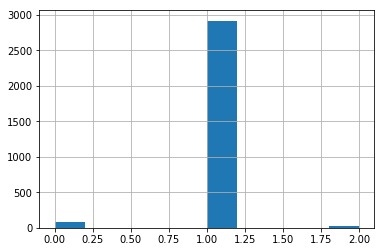

In [1035]:
dfA.PredictedAir.hist()

In [1503]:
aircutoff = 0 #| (dfA['PredictedAir']==2)
dfB = pd.DataFrame.copy(dfA[(dfA['PredictedAir']==0)])
varsC = ['MeanTheta','PoCAScat','GeoMeanFractionalScattering','MeanDoCA','box_p95',
         'GeoMeanPThetaSquared','Mu', 'MikesFOM', 'FracMu','x','y','StoppedMeanP','StoppedThroughRatio', 
         'sum_max_1_5', 'SmoothedNumPoCAs', 'box_mean']

dfB[varsC] = (dfB[varsC] - dfB[varsC].mean())/dfB[varsC].std()#(dfB[varsC].max()- dfB[varsC].min())

dfB['Int1'] = (dfB['GeoMeanFractionalScattering'])*dfB['x'] #dfB['PoCARate']*dfB['PoCAScat']*dfB['MeanDoCA']
dfB['Int2'] = (dfB['GeoMeanFractionalScattering'])*dfB['y']
#dfB['Int3'] = np.tanh(dfB['GeoMeanPThetaSquared'])/dfB['GeoMeanPThetaSquared']
dfB['Int4'] = ((dfB['MeanDoCA']))*dfB['x']
dfB['Int5'] = ((dfB['MeanDoCA']))*dfB['y']
#dfB['Int5'] = ((dfB['box_p95']*dfB['StoppedThroughRatio'])) 
#dfB['Int6'] = ((dfB['StoppedThroughRatio']/dfB['GeoMeanFractionalScattering'])) 
#dfB['Int7'] = ((dfB['box_p95']*dfB['GeoMeanPThetaSquared']))
#dfB['Int8'] = ((dfB['box_p95']))

dfB['Int6'] = ((dfB['StoppedThroughRatio']))/dfB['GeoMeanFractionalScattering']
dfB['Int6'] = (dfB['Int6'] - dfB['Int6'].mean())/dfB['Int6'].std()
dfB['Int7'] = ((dfB['StoppedThroughRatio']))/dfB['GeoMeanPThetaSquared']
dfB['Int7'] = (dfB['Int7'] - dfB['Int7'].mean())/dfB['Int7'].std()
dfB['Int10'] = ((dfB['GeoMeanFractionalScattering']))*dfB['StoppedMeanP']

dfB['Int8'] = ((dfB['MeanTheta']))*dfB['x']
dfB['Int9'] = ((dfB['MeanTheta']))*dfB['y']
dfB['Int11'] = ((dfB['FracMu']))/dfB['MikesFOM']

dfB['Int12'] = ((dfB['box_std']))*dfB['box_p25']
dfB['Int12'] = (dfB['Int12'] - dfB['Int12'].mean())/dfB['Int12'].std()

dfB['Int13'] = np.tanh((dfB['box_mean'] - dfB['box_mean'].mean())/(dfB['box_mean'].std()))
dfB['Int14'] = np.sin((dfB['MeanTheta'] - dfB['MeanTheta'].mean())/(dfB['MeanTheta'].std()))
dfB['Int15'] = np.cos((dfB['ScatteringRatio'] - dfB['ScatteringRatio'].min())/(dfB['ScatteringRatio'].mean()))
dfB['Int13'] = (dfB['Int13'] - dfB['Int13'].mean())/dfB['Int13'].std()
dfB['Int15'] = (dfB['Int15'] - dfB['Int15'].mean())/dfB['Int15'].std()

dfB = dfB[['sum_max_1_5', 'GeoMeanFractionalScattering', 'MeanDoCA', #'GeoMeanPThetaSquared',#'sum_max_1_5' 
            'Int13','Int15', #'GeoMeanPThetaSquared', #'box_std','box_p25',
           #'x','y',
           'Int7', 'Int6','Int12'#,'Int11', 'Int12'
           ]]#,'Int3','Int2','Int4','Int5','Int6','Int7','Int8']]

test = pdist(dfB, 'cityblock')
test1= pd.DataFrame(squareform(test), index=dfB.index, columns= dfB.index)
tsne_fit = test1
eps1 = abs((pd.DataFrame(tsne_fit).quantile(0.70).quantile(0.65)))
dbs=DBSCAN(eps=eps1, min_samples=1, leaf_size=1).fit((tsne_fit))
t=pd.Series(dbs.labels_,index=dfB.index)
    ## end dbscan clustering

s = pd.DataFrame(t.value_counts())
s.columns=['counts']
s['clusters'] = s.index
s['clusters'] = s['clusters'].apply(lambda x: x if x in s[s['counts'] >10]['clusters'] else -1)
t.value_counts()

1    65
0    17
8     1
7     1
6     1
5     1
4     1
3     1
2     1
dtype: int64

In [1487]:
dfB.describe()

,sum_max_1_5,GeoMeanFractionalScattering,MeanDoCA,Int13,Int15,Int7,Int6,Int12
count,8.900000e+01,8.900000e+01,8.900000e+01,8.900000e+01,89.000000,8.900000e+01,8.900000e+01,8.900000e+01
mean,-9.480556e-17,5.367741e-15,-1.839976e-15,-3.118604e-17,0.952401,6.549068e-17,-3.368092e-17,2.345190e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.039762,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.901514e+00,-1.605365e+00,-2.295597e+00,-1.298309e+00,0.844872,-2.690422e+00,-9.571213e-01,-1.085542e+00
25%,-5.719492e-01,-8.317124e-01,-7.581723e-01,-8.929721e-01,0.923017,-9.271734e-02,-1.169883e-01,-7.716744e-01
50%,2.292144e-01,1.319679e-01,1.907524e-01,-9.787075e-02,0.964465,-7.337803e-02,-1.026874e-01,-2.551248e-01
75%,7.362222e-01,7.706573e-01,6.472829e-01,9.974610e-01,0.985585,-4.592966e-02,-8.187765e-02,7.836289e-01
max,1.741654e+00,2.027938e+00,2.076759e+00,1.487443e+00,1.000000,8.923912e+00,9.204278e+00,2.672311e+00


In [1499]:
#dfB.describe() 

# assign -1 to anything below 5
s = pd.DataFrame(t.value_counts())
s.columns=['counts']
s['clusters'] = s.index
s['clustersnew'] = s['clusters'].apply(lambda x: x+1 if x in s[s['counts'] >10]['clusters'] else 0)
t1 = pd.DataFrame(t)
t1.columns=['oldclusters']
t1['recordid'] = t1.index
renamed = pd.merge(t1, s, how='outer', left_on='oldclusters', right_on='clusters')
renamed

,oldclusters,recordid,counts,clusters,clustersnew
0,0,574,17,0,1
1,0,575,17,0,1
2,0,576,17,0,1
3,0,578,17,0,1
4,0,579,17,0,1
5,0,580,17,0,1
6,0,592,17,0,1
7,0,849,17,0,1
8,0,850,17,0,1
9,0,851,17,0,1


In [1500]:
  #  ## dbscan clustering portion
dfB['joinkey'] = dfB.index
dfB = pd.merge(dfB, renamed, how = 'outer', left_on='joinkey', right_on='recordid')  
dfB['AssignedMaterials'] = dfB['clustersnew']
dfB.index = dfB['joinkey']
dfB['x'] = dfA['x'][dfA['PredictedAir']==0]
dfB['y'] = dfA['y'][dfA['PredictedAir']==0]
dfB['z'] = dfA['z'][dfA['PredictedAir']==0]
dfB.AssignedMaterials = dfB.AssignedMaterials.astype(int)
dfA['AssignedMaterials'] = 0
#dfB1=pd.DataFrame(dfB['AssignedMaterials'])
#dfA['AssignedMaterials'] = 0
#df3 = dfA.merge(dfB1, how='outer', left_index=True, right_index=True)
#  
df3 = dfA[['x','y','z','AssignedMaterials']][(dfA['PredictedAir']==1)| (dfA['PredictedAir']==2)].append(dfB[['x','y','z',
                        'AssignedMaterials']])
''' 
listoftests = list(itertools.combinations(df3['AssignedMaterials'].unique(), 2))

for cat in listoftests:
    cat1 = df3['Int1'][df3['AssignedMaterials']==cat[0]]
    cat2 = df3['Int1'][df3['AssignedMaterials']==cat[1]]
    print(cat, ttest_ind(cat1, cat2)[1])
    if ttest_ind(cat1, cat2)[1] > 0.15:
        df3['AssignedMaterials'] = df3['AssignedMaterials'].apply(lambda x: cat[0] if x==cat[1] else x)

        
listoftests = list(itertools.combinations(df3['AssignedMaterials'].unique(), 2))

for cat in listoftests:
    cat1 = df3['Int2'][df3['AssignedMaterials']==cat[0]]
    cat2 = df3['Int2'][df3['AssignedMaterials']==cat[1]]
    print(cat, ttest_ind(cat1, cat2)[1])
    if ttest_ind(cat1, cat2)[1] > 0.15:
        df3['AssignedMaterials'] = df3['AssignedMaterials'].apply(lambda x: cat[0] if x==cat[1] else x)

listoftests = list(itertools.combinations(df3['AssignedMaterials'].unique(), 2))

for cat in listoftests:
    cat1 = df3['Int3'][df3['AssignedMaterials']==cat[0]]
    cat2 = df3['Int3'][df3['AssignedMaterials']==cat[1]]
    print(cat, ttest_ind(cat1, cat2)[1])
    if ttest_ind(cat1, cat2)[1] > 0.11:
        df3['AssignedMaterials'] = df3['AssignedMaterials'].apply(lambda x: cat[0] if x==cat[1] else x)
        
listoftests = list(itertools.combinations(df3['AssignedMaterials'].unique(), 2))
for cat in listoftests:
    cat1 = df3['Int4'][df3['AssignedMaterials']==cat[0]]
    cat2 = df3['Int4'][df3['AssignedMaterials']==cat[1]]
    if ttest_ind(cat1, cat2)[1] > 0.11:
        df3['AssignedMaterials'] = df3['AssignedMaterials'].apply(lambda x: cat[0] if x==cat[1] else x)
        
listoftests = list(itertools.combinations(df3['AssignedMaterials'].unique(), 2))

for cat in listoftests:
    cat1 = df3['Int5'][df3['AssignedMaterials']==cat[0]]
    cat2 = df3['Int5'][df3['AssignedMaterials']==cat[1]]
    print(cat, ttest_ind(cat1, cat2)[1])
    if ttest_ind(cat1, cat2)[1] > 0.11:
        df3['AssignedMaterials'] = df3['AssignedMaterials'].apply(lambda x: cat[0] if x==cat[1] else x)        
'''
# checks objects for spacial consistency
df3 = df3.sort_values(by=['z','y','x'])
testIm = df3['AssignedMaterials'].values.reshape(11,25,11)
all_labels = measure.label(testIm, connectivity = 3, background=0)
all_labels_df = pd.DataFrame(all_labels.reshape(11*25*11))
df3['NPObjects'] = all_labels_df
df3.AssignedMaterials = df3.AssignedMaterials.astype(int)

s = df3['NPObjects'].value_counts().to_frame()
s['clusters'] = s.index
df3['NPObjects1'] = df3['NPObjects'].apply(lambda x: x if x in s[s['NPObjects'] >5]['clusters'] else 0)
#df3 = df3.sort_values(by=['x','y','z'])
'''
listoftests = list(itertools.combinations(df3['NPObjects1'].unique()[1:], 2))

for cat in listoftests:
    cat1 = df3['Int4'][df3['NPObjects1']==cat[0]]
    cat2 = df3['Int4'][df3['NPObjects1']==cat[1]]
    if ttest_ind(cat1, cat2)[1] > 0.05:
        df3['NPObjects1'] = df3['NPObjects1'].apply(lambda x: cat[0] if x==cat[1] else x)
'''        
#df_to_vti(df3, resample_factor = 4, column=['AssignedMaterials'], output_filename='Materials20258_540_New.vti')

"\nlistoftests = list(itertools.combinations(df3['NPObjects1'].unique()[1:], 2))\n\nfor cat in listoftests:\n  cat1 = df3['Int4'][df3['NPObjects1']==cat[0]]\n  cat2 = df3['Int4'][df3['NPObjects1']==cat[1]]\n  if ttest_ind(cat1, cat2)[1] > 0.05:\n      df3['NPObjects1'] = df3['NPObjects1'].apply(lambda x: cat[0] if x==cat[1] else x)\n"

In [962]:
df_to_vti(df3, resample_factor = 4, column=['NPObjects1'], output_filename='Materials20310_120_3Class.vti')

In [1495]:
df3['AssignedMaterials'].value_counts()

0    2979
1      17
5      16
3      13
Name: AssignedMaterials, dtype: int64

In [1496]:
df3['NPObjects1'].value_counts()
#df_to_vti(df3, resample_factor = 4, column=['NPObjects1'], output_filename='Materials20258_570_New.vti')

0    2983
4      16
5       9
2       9
1       8
Name: NPObjects1, dtype: int64

In [1501]:
## plot materials
colors = ['rgb(0,0,0)', 'rgb(0,0,255)','rgb(255,0,0)', 'rgb(0,255,0)', 'rgb(0,128,255)', 'rgb(255,0,255)'
          , 'rgb(255,255,51)', 'rgb(255,229,209)', 'rgb(0,255,255)']
opacity_s = ['0.01','1','1','1','1','1','1','1','1']
data = []
plot_var = 'AssignedMaterials'
for i in range(len(df3[plot_var].unique())):
    name = np.sort(df3[plot_var].unique())[i]
    color = colors[i]
    opacity = opacity_s[i]
    x = df3[ df3[plot_var] == name ]['x']
    y = df3[ df3[plot_var] == name ]['y']
    z = df3[ df3[plot_var] == name ]['z']
    
    trace = dict(
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=5, color=color, line=dict(width=0), opacity=opacity ) )
    data.append( trace )
    
layout = go.Layout(
    title='dfB[[Int1,Int3,Int2,Int4]]'
)

#plotly.offline.plot([trace, layout])
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig)    

'file:///home/rvozdolska/Downloads/temp-plot.html'

In [431]:
## plot air
colors = ['rgb(0,0,255)', 'rgb(0,0,0)','rgb(255,0,0)', 'rgb(0,255,0)', 'rgb(0,128,255)', 'rgb(255,0,255)'
          , 'rgb(255,255,51)', 'rgb(255,229,209)', 'rgb(0,255,255)']
opacity_s = ['1','0.01','1','1','1','1','1','1','1']
data = []
plot_var = 'PredictedAir'
dfA=dfA.sort_values(by=['x','y','z'])
for i in range(len(dfA[plot_var].unique())):
    name = np.sort(dfA[plot_var].unique())[i]
    color = colors[i]
    opacity = opacity_s[i]
    x = dfA[ dfA[plot_var] == name ]['x']
    y = dfA[ dfA[plot_var] == name ]['y']
    z = dfA[ dfA[plot_var] == name ]['z']
    
    trace = dict(
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=5, color=color, line=dict(width=0), opacity=opacity ) )
    data.append( trace )
    
layout = go.Layout(
    title='dfB[[Int1,Int3,Int2,Int4]]'
)

#plotly.offline.plot([trace, layout])
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig)    

'file:///home/rvozdolska/Downloads/temp-plot.html'